In [1]:
import random
import numpy as np
from matplotlib import pyplot as plt
import cv2
from lxml import etree
from sklearn.model_selection import train_test_split
from glob import glob
from os.path import join
from os import listdir
from keras.models import Sequential
from keras.layers import Dense, Flatten
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
image_input_size = 224
image_folder_name = 'C:\\Users\\AKSHAY\\OneDrive\\Desktop\\project\\images'
label_folder_name = 'C:\\Users\\AKSHAY\\OneDrive\\Desktop\\project\\annotations'


In [3]:
def read_images(image_size=image_input_size):
    images_paths = join(image_folder_name, '*g')
    image_files = glob(images_paths)
    image_files = sorted(image_files)
    original_images = []
    for i, single_file in enumerate(image_files):
        original_img = cv2.resize(cv2.imread(single_file), (image_size, image_size))
        original_images.append(np.array(original_img))
    original_images = np.array(original_images)
    print(f'Final Label Shape is {original_images.shape}')
    return original_images


def print_sample_image(original_img):
    fig, ax = plt.subplots(5, 5, figsize=(16, 16))
    for row in range(5):
        for col in range(5):
            index = random.randint(0, len(original_img) - 1)
            ax[row][col].imshow(original_img[index])
            ax[row][col].axis('off')
    plt.show()

In [4]:
def read_label(image_size=image_input_size):
    labels_paths = listdir(label_folder_name)
    labels_paths = sorted(labels_paths)
    labels = np.zeros((len(labels_paths), 4, 1), dtype=int)
    for i, single_label in enumerate(labels_paths):
        final_label_path = join(label_folder_name, single_label)
        file_tree = etree.parse(final_label_path)
        image_width = list(file_tree.xpath('size'))[-1].xpath('width')[0].text
        image_height = list(file_tree.xpath('size'))[-1].xpath('height')[0].text
        image_width = int(image_width)
        image_height = int(image_height)
        x2 = int(list(file_tree.xpath('object/bndbox'))[-1].xpath("xmax")[0].text)
        x2 = int(x2 / (image_width / image_size))

        y2 = int(list(file_tree.xpath('object/bndbox'))[-1].xpath("ymax")[0].text)
        y2 = int(y2 / (image_height / image_size))

        x1 = int(list(file_tree.xpath('object/bndbox'))[-1].xpath("xmin")[0].text)
        x1 = int(x1 / (image_width / image_size))

        y1 = int(list(file_tree.xpath('object/bndbox'))[-1].xpath("ymin")[0].text)
        y1 = int(y1 / (image_height / image_size))

        labels[i] = np.array([x2, y2, x1, y1]).reshape(-1, 1)
    print(f'Final Label Shape is {labels.shape}')
    return labels


def draw_bounding_box(original_img, labels):
    index = random.randint(0, len(original_img) - 1)
    rect = list(labels[index])
    fig = cv2.rectangle(original_img[index], (rect[0][0], rect[1][0]), (rect[2][0], rect[3][0]), (255, 0, 0))
    plt.imshow(fig)
    plt.title(f'Image and bounding box for image {index}')
    plt.show()

In [5]:
def process_data(orginal_img, labels):
    orginal_img = orginal_img.astype(float) / 255
    labels = labels.astype(float) / 255
    labels = labels.reshape(-1, 4)
    for i, img in enumerate(orginal_img):
        blurImg = cv2.blur(img, (10, 10))
        kernel = np.array([[0, -1, 0],
                           [-1, 5, -1],
                           [0, -1, 0]])
        image_sharp = cv2.filter2D(src=blurImg, ddepth=-1, kernel=kernel)
        orginal_img[i] = image_sharp
    X_train, X_test, y_train, y_test = train_test_split(orginal_img, labels, test_size=0.3, random_state=42)
    return X_train, X_test, y_train, y_test


def vgg_model(input_shape=(image_input_size, image_input_size, 3),
              output_shape=4):
    first_layer = 128
    second_layer = 64
    current_model = Sequential()
    current_model.add(VGG16(weights="imagenet", include_top=False, input_shape=input_shape))
    current_model.add(Flatten())
    current_model.add(Dense(first_layer, activation="relu"))
    current_model.add(Dense(first_layer, activation="relu"))
    current_model.add(Dense(second_layer, activation="relu"))
    current_model.add(Dense(output_shape, activation="sigmoid"))

    current_model.layers[-6].trainable = False
    # current_model.summary()

    current_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

    return current_model


def fit_vgg(X_train, X_test, y_train, y_test):
    callback = [
        ModelCheckpoint('vgg_16.pk', monitor='loss', mode='min', save_best_only=True),
    ]
    vgg_16_current_model = vgg_model()
    history = vgg_16_current_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1, callbacks=callback)
    print('Accuracy score for the testing dataset', vgg_16_current_model.evaluate(X_test, y_test))
    print('Accuracy score for the training dataset', vgg_16_current_model.evaluate(X_train, y_train))

    return vgg_16_current_model


def inception_model(input_shape=(image_input_size, image_input_size, 3),
                    output_shape=4):
    first_layer = 128
    second_layer = 64
    current_model = Sequential()
    current_model.add(InceptionV3(weights="imagenet", include_top=False, input_shape=input_shape))
    current_model.add(Flatten())
    current_model.add(Dense(first_layer, activation="relu"))
    current_model.add(Dense(first_layer, activation="relu"))
    current_model.add(Dense(second_layer, activation="relu"))
    current_model.add(Dense(output_shape, activation="sigmoid"))

    current_model.layers[-6].trainable = False
    # current_model.summary()

    current_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

    return current_model


def fit_inception(X_train, X_test, y_train, y_test):
    callback = [
        ModelCheckpoint('inception.pk', monitor='loss', mode='min', save_best_only=True),
    ]
    inception = inception_model()
    history = inception.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1, callbacks=callback)
    print('Accuracy score for the testing dataset', inception.evaluate(X_test, y_test))
    print('Accuracy score for the training dataset', inception.evaluate(X_train, y_train))

    return inception


def mobile_net(input_shape=(image_input_size, image_input_size, 3),
               output_shape=4):
    first_layer = 128
    second_layer = 64
    current_model = Sequential()
    current_model.add(MobileNet(weights="imagenet", include_top=False, input_shape=input_shape))
    current_model.add(Flatten())
    current_model.add(Dense(first_layer, activation="relu"))
    current_model.add(Dense(first_layer, activation="relu"))
    current_model.add(Dense(second_layer, activation="relu"))
    current_model.add(Dense(output_shape, activation="sigmoid"))

    current_model.layers[-6].trainable = False
    # current_model.summary()

    current_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

    return current_model


def fit_mobile_net(X_train, X_test, y_train, y_test):
    print('Training Mobile Net')
    callback = [
        ModelCheckpoint('mobile_net.pk', monitor='accuracy', mode='max', save_best_only=True),
    ]
    mobile_net_current_model = mobile_net()
    history = mobile_net_current_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1, callbacks=callback)
    print('Accuracy score for the testing dataset', mobile_net_current_model.evaluate(X_test, y_test))
    print('Accuracy score for the training dataset', mobile_net_current_model.evaluate(X_train, y_train))

    return mobile_net_current_model

Final Label Shape is (433, 224, 224, 3)


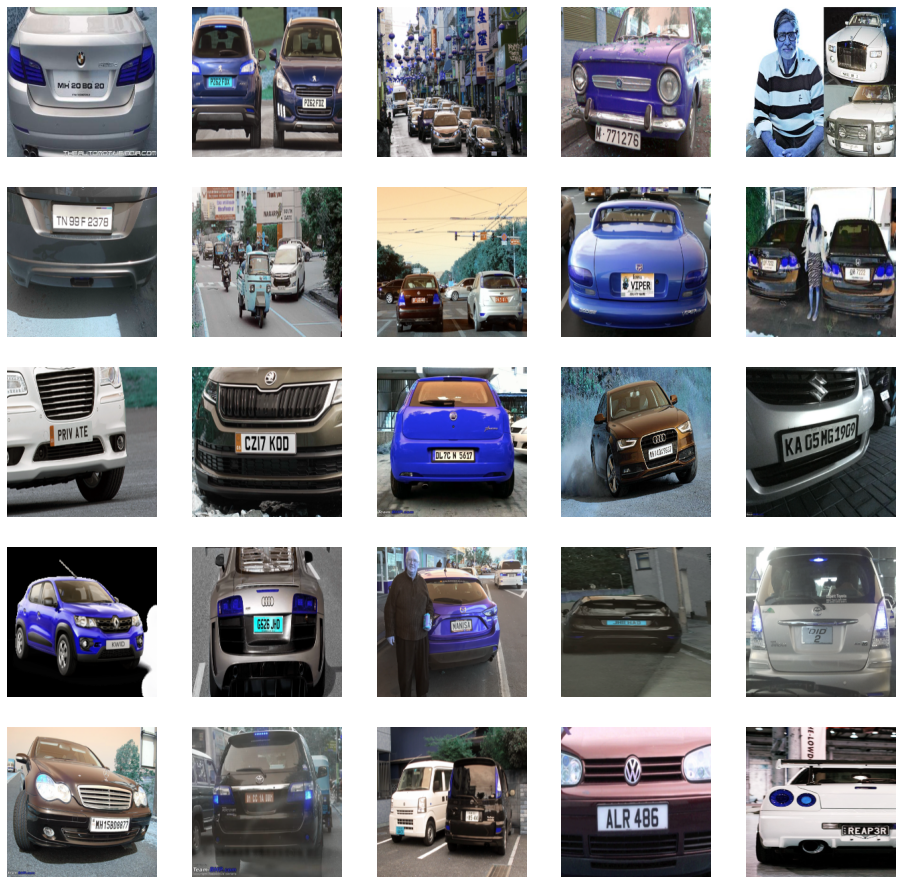

Final Label Shape is (433, 4, 1)


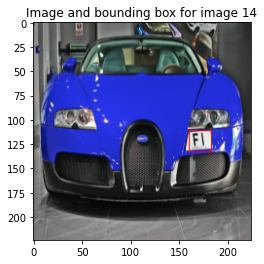

In [6]:
original_img = read_images()
print_sample_image(original_img)
labels = read_label()
draw_bounding_box(original_img, labels)
X_train, X_test, y_train, y_test = process_data(original_img, labels)

In [7]:
fit_vgg(X_train, X_test, y_train, y_test)

Epoch 1/20
10/10 [==============================] - ETA: 0s - loss: 0.0425 - accuracy: 0.3696

INFO:tensorflow:Assets written to: vgg_16.pk\assets


INFO:tensorflow:Assets written to: vgg_16.pk\assets


10/10 [==============================] - 66s 7s/step - loss: 0.0425 - accuracy: 0.3696
Epoch 2/20
10/10 [==============================] - ETA: 0s - loss: 0.0195 - accuracy: 0.5050

INFO:tensorflow:Assets written to: vgg_16.pk\assets


INFO:tensorflow:Assets written to: vgg_16.pk\assets


10/10 [==============================] - 69s 7s/step - loss: 0.0195 - accuracy: 0.5050
Epoch 3/20
10/10 [==============================] - ETA: 0s - loss: 0.0124 - accuracy: 0.6073

INFO:tensorflow:Assets written to: vgg_16.pk\assets


INFO:tensorflow:Assets written to: vgg_16.pk\assets


10/10 [==============================] - 71s 7s/step - loss: 0.0124 - accuracy: 0.6073
Epoch 4/20
10/10 [==============================] - ETA: 0s - loss: 0.0083 - accuracy: 0.8383

INFO:tensorflow:Assets written to: vgg_16.pk\assets


INFO:tensorflow:Assets written to: vgg_16.pk\assets


10/10 [==============================] - 72s 7s/step - loss: 0.0083 - accuracy: 0.8383
Epoch 5/20
10/10 [==============================] - ETA: 0s - loss: 0.0063 - accuracy: 0.8713

INFO:tensorflow:Assets written to: vgg_16.pk\assets


INFO:tensorflow:Assets written to: vgg_16.pk\assets


10/10 [==============================] - 71s 7s/step - loss: 0.0063 - accuracy: 0.8713
Epoch 6/20
10/10 [==============================] - ETA: 0s - loss: 0.0048 - accuracy: 0.8977

INFO:tensorflow:Assets written to: vgg_16.pk\assets


INFO:tensorflow:Assets written to: vgg_16.pk\assets


10/10 [==============================] - 65s 7s/step - loss: 0.0048 - accuracy: 0.8977
Epoch 7/20
10/10 [==============================] - ETA: 0s - loss: 0.0044 - accuracy: 0.9043

INFO:tensorflow:Assets written to: vgg_16.pk\assets


INFO:tensorflow:Assets written to: vgg_16.pk\assets


10/10 [==============================] - 66s 7s/step - loss: 0.0044 - accuracy: 0.9043
Epoch 8/20
10/10 [==============================] - ETA: 0s - loss: 0.0033 - accuracy: 0.9241

INFO:tensorflow:Assets written to: vgg_16.pk\assets


INFO:tensorflow:Assets written to: vgg_16.pk\assets


10/10 [==============================] - 64s 7s/step - loss: 0.0033 - accuracy: 0.9241
Epoch 9/20
10/10 [==============================] - ETA: 0s - loss: 0.0021 - accuracy: 0.9010

INFO:tensorflow:Assets written to: vgg_16.pk\assets


INFO:tensorflow:Assets written to: vgg_16.pk\assets


10/10 [==============================] - 61s 6s/step - loss: 0.0021 - accuracy: 0.9010
Epoch 10/20
10/10 [==============================] - ETA: 0s - loss: 0.0015 - accuracy: 0.9340

INFO:tensorflow:Assets written to: vgg_16.pk\assets


INFO:tensorflow:Assets written to: vgg_16.pk\assets


10/10 [==============================] - 59s 6s/step - loss: 0.0015 - accuracy: 0.9340
Epoch 11/20
10/10 [==============================] - ETA: 0s - loss: 0.0013 - accuracy: 0.9571

INFO:tensorflow:Assets written to: vgg_16.pk\assets


INFO:tensorflow:Assets written to: vgg_16.pk\assets


10/10 [==============================] - 60s 6s/step - loss: 0.0013 - accuracy: 0.9571
Epoch 12/20
10/10 [==============================] - ETA: 0s - loss: 0.0011 - accuracy: 0.9538

INFO:tensorflow:Assets written to: vgg_16.pk\assets


INFO:tensorflow:Assets written to: vgg_16.pk\assets


10/10 [==============================] - 64s 7s/step - loss: 0.0011 - accuracy: 0.9538
Epoch 13/20
10/10 [==============================] - ETA: 0s - loss: 9.8438e-04 - accuracy: 0.9406

INFO:tensorflow:Assets written to: vgg_16.pk\assets


INFO:tensorflow:Assets written to: vgg_16.pk\assets


10/10 [==============================] - 66s 7s/step - loss: 9.8438e-04 - accuracy: 0.9406
Epoch 14/20
10/10 [==============================] - ETA: 0s - loss: 7.5589e-04 - accuracy: 0.9736

INFO:tensorflow:Assets written to: vgg_16.pk\assets


INFO:tensorflow:Assets written to: vgg_16.pk\assets


10/10 [==============================] - 84s 9s/step - loss: 7.5589e-04 - accuracy: 0.9736
Epoch 15/20
10/10 [==============================] - 63s 6s/step - loss: 8.0693e-04 - accuracy: 0.9274
Epoch 16/20
10/10 [==============================] - 60s 6s/step - loss: 8.6673e-04 - accuracy: 0.9472
Epoch 17/20
10/10 [==============================] - ETA: 0s - loss: 6.7355e-04 - accuracy: 0.9472

INFO:tensorflow:Assets written to: vgg_16.pk\assets


INFO:tensorflow:Assets written to: vgg_16.pk\assets


10/10 [==============================] - 83s 8s/step - loss: 6.7355e-04 - accuracy: 0.9472
Epoch 18/20
10/10 [==============================] - 63s 7s/step - loss: 7.7160e-04 - accuracy: 0.9406
Epoch 19/20
10/10 [==============================] - ETA: 0s - loss: 6.2794e-04 - accuracy: 0.9637

INFO:tensorflow:Assets written to: vgg_16.pk\assets


INFO:tensorflow:Assets written to: vgg_16.pk\assets


10/10 [==============================] - 78s 8s/step - loss: 6.2794e-04 - accuracy: 0.9637
Epoch 20/20
5/5 [==============================] - 28s 5s/step - loss: 0.0082 - accuracy: 0.8385
Accuracy score for the testing dataset [0.008248955942690372, 0.8384615182876587]
10/10 [==============================] - 64s 6s/step - loss: 5.9800e-04 - accuracy: 0.9241
Accuracy score for the training dataset [0.0005979958223178983, 0.9240924119949341]


In [8]:
fit_inception(X_train, X_test, y_train, y_test)

Epoch 1/20
10/10 [==============================] - ETA: 0s - loss: 0.2035 - accuracy: 0.4026

INFO:tensorflow:Assets written to: inception.pk\assets


INFO:tensorflow:Assets written to: inception.pk\assets


10/10 [==============================] - 109s 11s/step - loss: 0.2035 - accuracy: 0.4026
Epoch 2/20
10/10 [==============================] - 11s 1s/step - loss: 0.2313 - accuracy: 0.5578
Epoch 3/20
10/10 [==============================] - 11s 1s/step - loss: 0.2313 - accuracy: 0.5578
Epoch 4/20
10/10 [==============================] - 16s 2s/step - loss: 0.2313 - accuracy: 0.5578
Epoch 5/20
10/10 [==============================] - 16s 2s/step - loss: 0.2313 - accuracy: 0.5578
Epoch 6/20
10/10 [==============================] - 16s 2s/step - loss: 0.2313 - accuracy: 0.5578
Epoch 7/20
10/10 [==============================] - 15s 2s/step - loss: 0.2313 - accuracy: 0.5578
Epoch 8/20
10/10 [==============================] - 15s 1s/step - loss: 0.2313 - accuracy: 0.5578
Epoch 9/20
10/10 [==============================] - 16s 2s/step - loss: 0.2313 - accuracy: 0.5578
Epoch 10/20
10/10 [==============================] - 16s 2s/step - loss: 0.2313 - accuracy: 0.5578
Epoch 11/20
10/10 [=========

In [9]:
fit_mobile_net(X_train, X_test, y_train, y_test)

Training Mobile Net
Epoch 1/20
10/10 [==============================] - ETA: 0s - loss: 0.2534 - accuracy: 0.4587

INFO:tensorflow:Assets written to: mobile_net.pk\assets


INFO:tensorflow:Assets written to: mobile_net.pk\assets


10/10 [==============================] - 57s 5s/step - loss: 0.2534 - accuracy: 0.4587
Epoch 2/20
10/10 [==============================] - 6s 627ms/step - loss: 0.2872 - accuracy: 0.4422
Epoch 3/20
10/10 [==============================] - 6s 573ms/step - loss: 0.2872 - accuracy: 0.4422
Epoch 4/20
10/10 [==============================] - 6s 589ms/step - loss: 0.2872 - accuracy: 0.4422
Epoch 5/20
10/10 [==============================] - 6s 645ms/step - loss: 0.2872 - accuracy: 0.4422
Epoch 6/20
10/10 [==============================] - 7s 656ms/step - loss: 0.2872 - accuracy: 0.4422
Epoch 7/20
10/10 [==============================] - 8s 808ms/step - loss: 0.2872 - accuracy: 0.4422
Epoch 8/20
10/10 [==============================] - 10s 998ms/step - loss: 0.2872 - accuracy: 0.4422
Epoch 9/20
10/10 [==============================] - 9s 903ms/step - loss: 0.2872 - accuracy: 0.4422
Epoch 10/20
10/10 [==============================] - 8s 823ms/step - loss: 0.2872 - accuracy: 0.4422
Epoch 11/20